# Clasificación del sentimiento en Tweets de Donald Trump

## Análisis descriptivo de los datos

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import import_ipynb
from sklearn.externals import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
cols = ['source','text','created_at','retweet_count','favorite_count','is_retweet','id_str']

In [3]:
df_Trump_Initial = pd.read_csv("./DataSheet_..trumptwitterarchive_com_archive.csv",header=0,delimiter=';', encoding='latin-1')

In [4]:
df_Trump_Initial.head()

source                                               text  \
0  Twitter for iPhone  So Obama and his team of lowlifes spied on my ...   
1  Twitter for iPhone  96% Approval Rating in the Republican Party. T...   
2  Twitter for iPhone  RT @stoolpresidente: (PART 3) - @realDonaldTru...   
3  Twitter for iPhone  RT @stoolpresidente: (PART 2) - @realDonaldTru...   
4  Twitter for iPhone  RT @stoolpresidente: (PART 1) - I did not expe...   

            created_at retweet_count favorite_count is_retweet  \
0  07-24-2020 23:38:05         73351         288144      false   
1  07-24-2020 22:57:57         31016         209238      false   
2  07-24-2020 21:45:30         17169              0       true   
3  07-24-2020 21:45:27         16036              0       true   
4  07-24-2020 21:45:25         28520              0       true   

                id_str Unnamed: 7 Unnamed: 8 Unnamed: 9  Unnamed: 10  
0  1286807899314872320        NaN        NaN        NaN          NaN  
1  1286797798847860736        NaN        NaN        NaN          NaN  
2  1286779564627316736        NaN        NaN        NaN          NaN  
3  1286779555764744193        NaN        NaN        NaN          NaN  
4  1286779546612703232        NaN        NaN        NaN          NaN

In [5]:
df_Trump_Initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31115 entries, 0 to 31114
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   source          31115 non-null  object 
 1   text            31115 non-null  object 
 2   created_at      31114 non-null  object 
 3   retweet_count   31115 non-null  object 
 4   favorite_count  31115 non-null  object 
 5   is_retweet      31057 non-null  object 
 6   id_str          31115 non-null  object 
 7   Unnamed: 7      489 non-null    object 
 8   Unnamed: 8      78 non-null     object 
 9   Unnamed: 9      13 non-null     object 
 10  Unnamed: 10     4 non-null      float64
dtypes: float64(1), object(10)
memory usage: 2.6+ MB


In [6]:
del(df_Trump_Initial['Unnamed: 7'])
del(df_Trump_Initial['Unnamed: 8'])
del(df_Trump_Initial['Unnamed: 9'])
del(df_Trump_Initial['Unnamed: 10'])
df_Trump_Initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31115 entries, 0 to 31114
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source          31115 non-null  object
 1   text            31115 non-null  object
 2   created_at      31114 non-null  object
 3   retweet_count   31115 non-null  object
 4   favorite_count  31115 non-null  object
 5   is_retweet      31057 non-null  object
 6   id_str          31115 non-null  object
dtypes: object(7)
memory usage: 1.7+ MB


In [7]:
df_Trump_Initial_Date=df_Trump_Initial.created_at
df_Trump_Initial_Date

0        07-24-2020 23:38:05
1        07-24-2020 22:57:57
2        07-24-2020 21:45:30
3        07-24-2020 21:45:27
4        07-24-2020 21:45:25
                ...         
31110    12-31-2014 15:50:39
31111    12-31-2014 15:45:09
31112    12-31-2014 03:45:08
31113    12-31-2014 03:44:13
31114    12-31-2014 03:34:26
Name: created_at, Length: 31115, dtype: object

In [8]:
df_Trump_ToClean=pd.DataFrame({'mensaje': df_Trump_Initial.text, 'sentimiento': ""})
df_Trump_ToClean

mensaje sentimiento
0      So Obama and his team of lowlifes spied on my ...            
1      96% Approval Rating in the Republican Party. T...            
2      RT @stoolpresidente: (PART 3) - @realDonaldTru...            
3      RT @stoolpresidente: (PART 2) - @realDonaldTru...            
4      RT @stoolpresidente: (PART 1) - I did not expe...            
...                                                  ...         ...
31110  Without passion you don't have energy, without...            
31111  If you're interested in 'balancing' work and p...            
31112  @peter_upfield: @realDonaldTrump @frank_puggi ...            
31113  @SellingVA: @realDonaldTrump: Sometimes by los...            
31114  @frank_puggi: @realDonaldTrump @realDonaldTrum...            

[31115 rows x 2 columns]

In [9]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
import re as patternToDelete
from bs4 import BeautifulSoup

In [10]:
import unicodedata
from unidecode import unidecode

def deEmojify(inputString):
    returnString = ""
    for character in inputString:
        try:
            character.encode("ascii")
            returnString += character
        except UnicodeEncodeError:
            returnString += ''
    return returnString

In [11]:
patternToDelete1 = r'@[A-Za-z0-9_]+'
patternToDelete2 = r'https?://[^ ]+'
patternToDelete3 = r'rt? +'
patron = r'|'.join((patternToDelete1, patternToDelete2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
patronNegacion = patternToDelete.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
i=0
def limpieza_tweets(mensaje):
   
    #patternToDelete.sub('https?://[A-Za-z0-9./]+','',mensaje)
    out = BeautifulSoup(patternToDelete.sub('https?://[A-Za-z0-9./]+','',mensaje), 'lxml')
    out_souped = out.get_text()
    
    try:
        bom_borrado = out_souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_borrado = out_souped
        
    emoji_borrado = deEmojify(bom_borrado)
    mensajeAux = patternToDelete.sub(patron, '', emoji_borrado)  
    mensajeAux = patternToDelete.sub(www_pat, '', mensajeAux)
    lmensajeAux_lower_case = mensajeAux.lower()
    neg_handled = patronNegacion.sub(lambda x: negations_dic[x.group()], lmensajeAux_lower_case)
    mensajeSoloLetras = patternToDelete.sub("[^a-zA-Z]", " ", neg_handled)
    mensajeSoloLetras2 = patternToDelete.sub(patternToDelete3, " ", mensajeSoloLetras)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(mensajeSoloLetras2) if len(x) > 1]
    return (" ".join(words)).strip()


In [12]:
%%time
print ("Limpiando y parseando todos los tweets...\n")
print(df_Trump_ToClean)
tweetsLimpios = []
i=0
while i < len(df_Trump_ToClean):
    if( (i+1)%1000 == 0 ):
        print ("Tweets número %d de %d han sido procesados" % ( i+1, len(df_Trump_ToClean) ))                                                                    
    tweetsLimpios.append(limpieza_tweets(df_Trump_ToClean['mensaje'][i]))
    
    i += 1

Limpiando y parseando todos los tweets...

                                                 mensaje sentimiento
0      So Obama and his team of lowlifes spied on my ...            
1      96% Approval Rating in the Republican Party. T...            
2      RT @stoolpresidente: (PART 3) - @realDonaldTru...            
3      RT @stoolpresidente: (PART 2) - @realDonaldTru...            
4      RT @stoolpresidente: (PART 1) - I did not expe...            
...                                                  ...         ...
31110  Without passion you don't have energy, without...            
31111  If you're interested in 'balancing' work and p...            
31112  @peter_upfield: @realDonaldTrump @frank_puggi ...            
31113  @SellingVA: @realDonaldTrump: Sometimes by los...            
31114  @frank_puggi: @realDonaldTrump @realDonaldTrum...            

[31115 rows x 2 columns]
Tweets número 1000 de 31115 han sido procesados
Tweets número 2000 de 31115 han sido procesados
Tweets 

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:314: UserWarning: "b'....'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Tweets número 9000 de 31115 han sido procesados
Tweets número 10000 de 31115 han sido procesados
Tweets número 11000 de 31115 han sido procesados
Tweets número 12000 de 31115 han sido procesados
Tweets número 13000 de 31115 han sido procesados
Tweets número 14000 de 31115 han sido procesados
Tweets número 15000 de 31115 han sido procesados
Tweets número 16000 de 31115 han sido procesados
Tweets número 17000 de 31115 han sido procesados
Tweets número 18000 de 31115 han sido procesados
Tweets número 19000 de 31115 han sido procesados
Tweets número 20000 de 31115 han sido procesados
Tweets número 21000 de 31115 han sido procesados
Tweets número 22000 de 31115 han sido procesados
Tweets número 23000 de 31115 han sido procesados
Tweets número 24000 de 31115 han sido procesados
Tweets número 25000 de 31115 han sido procesados
Tweets número 26000 de 31115 han sido procesados
Tweets número 27000 de 31115 han sido procesados
Tweets número 28000 de 31115 han sido procesados
Tweets número 29000 d

In [13]:
tweetsLimpios

['so obama and his team of lowlifes spied on my campaign and got caught open and shut case more papers released today which are devastating to them will they eve pay the price the political crime of the century',
 'approval rating in the republican party thank you',
 'pa',
 'pa',
 'pa did not expect to interview at the white house yesterday but here we are',
 'president announces that as result of the executive orders he is signing today the heads of the majo',
 'president we will finally allow the safe and legal importation of prescription drugs from canada and othe',
 'president is taking historic action to reduce the price of prescription drugs',
 'live president delivers remarks on lowering drug prices',
 'congratulations',
 'spoke to highly respected chairman senato who has informed me that he will not be changing the names of ou great military bases and forts places from which we won two world wars and more like me jim is not believe in cancel culture',
 'will be interviewed by t

Procedo a la carga del modelo que mejores resultados me ha suministrado

In [14]:
modelo_t_tfidf=joblib.load('.\Modelos Entrenados\modelo_entrenado_t_tfidf.pkl')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code 

In [15]:
modelo=modelo_t_tfidf
y_pred_Trump = modelo.predict(tweetsLimpios)

In [16]:
y_pred_Trump

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [17]:
df_Trump_Classified=pd.DataFrame({'mensaje': tweetsLimpios, 'sentimiento': y_pred_Trump})



In [18]:
df_Trump_Classified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31115 entries, 0 to 31114
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mensaje      31115 non-null  object
 1   sentimiento  31115 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 486.3+ KB


Añado la columna fecha y reorganizo el dataframe.

In [19]:
df_Trump_Classified["fecha"]=df_Trump_Initial_Date
cols = df_Trump_Classified.columns.tolist()
cols = ['mensaje','fecha','sentimiento']
df_Trump_Classified= df_Trump_Classified[cols]

In [20]:
df_Trump_Classified

mensaje                fecha  \
0      so obama and his team of lowlifes spied on my ...  07-24-2020 23:38:05   
1      approval rating in the republican party thank you  07-24-2020 22:57:57   
2                                                     pa  07-24-2020 21:45:30   
3                                                     pa  07-24-2020 21:45:27   
4      pa did not expect to interview at the white ho...  07-24-2020 21:45:25   
...                                                  ...                  ...   
31110  without passion you do not have energy without...  12-31-2014 15:50:39   
31111  if you re interested in balancing work and ple...  12-31-2014 15:45:09   
31112                                     run donald run  12-31-2014 03:45:08   
31113  sometimes by losing battle you find new way to...  12-31-2014 03:44:13   
31114  if one man could get this fucking country back...  12-31-2014 03:34:26   

       sentimiento  
0                0  
1                1  
2                1  
3                1  
4                1  
...            ...  
31110            0  
31111            1  
31112            1  
31113            0  
31114            1  

[31115 rows x 3 columns]

In [21]:
df_Trump_Classified = df_Trump_Classified.drop(df_Trump_Classified[df_Trump_Classified['mensaje']==''].index)

In [22]:
df_Trump_Classified.to_csv("trumpAUX.csv")

In [23]:
df_Trump_Classified = pd.read_csv("trumpAUX.csv",index_col=0)

## Word Cloud

In [24]:

neg_tweets = df_Trump_Classified[df_Trump_Classified.sentimiento == 0]
neg_string = []
for t in neg_tweets.mensaje:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

(-0.5, 2399.5, 1422.5, -0.5)

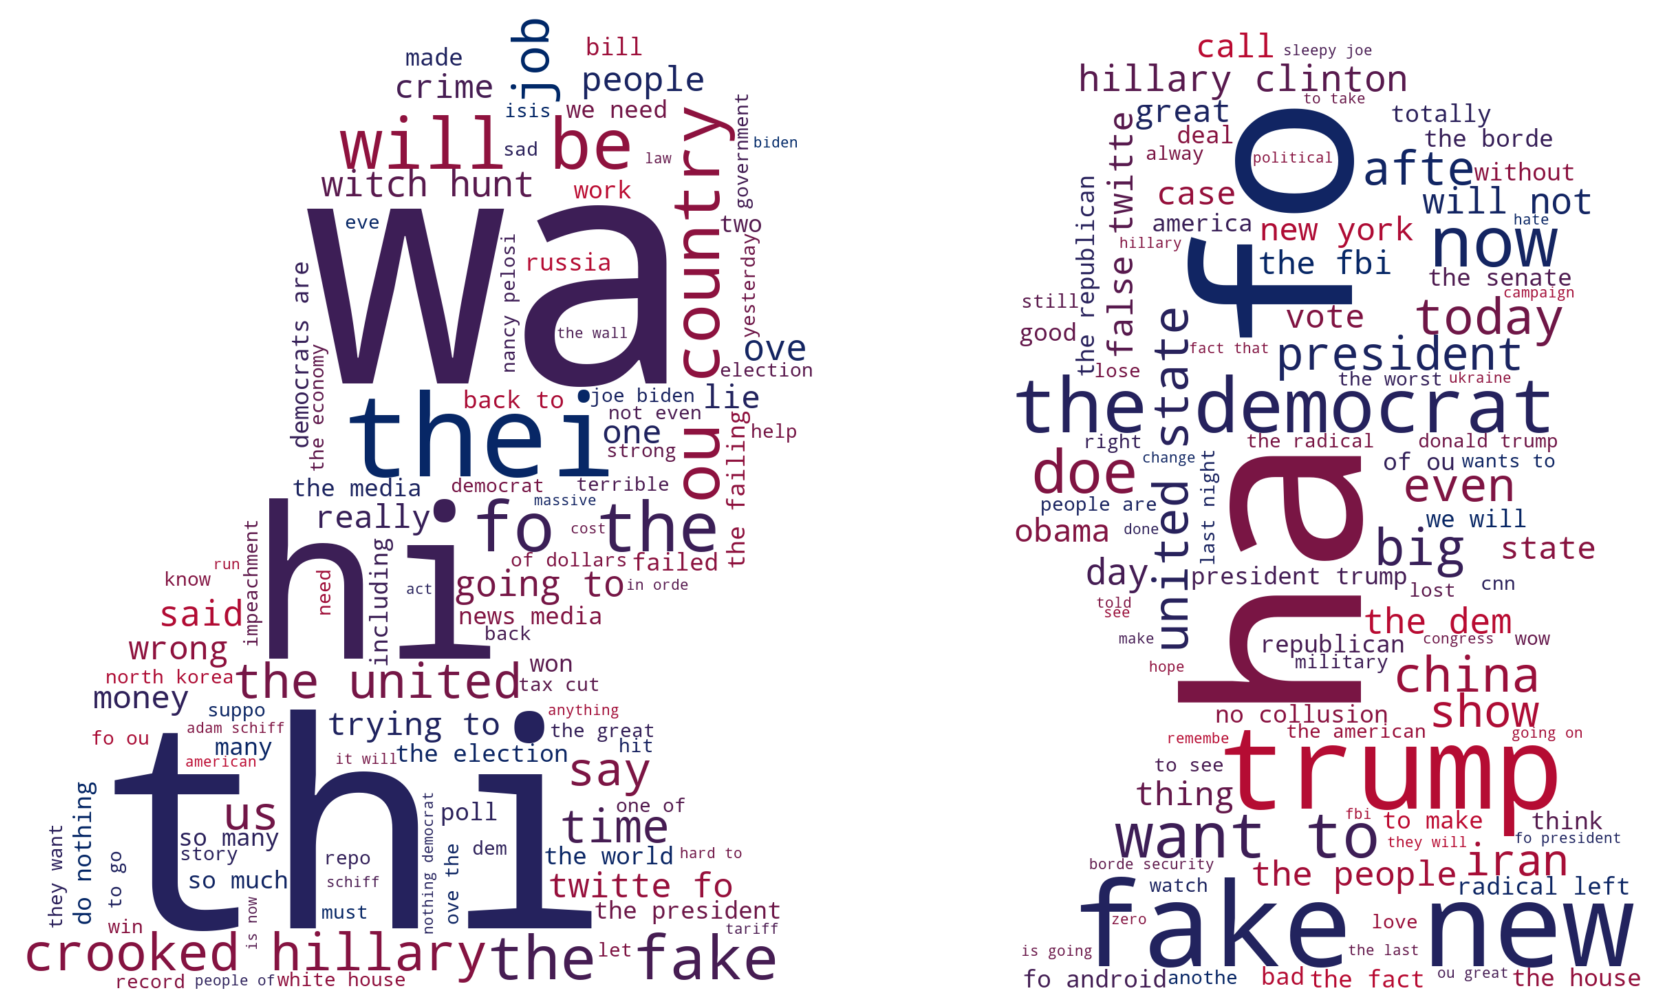

In [25]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)

mask = np.array(Image.open("trump.jpg"))
colors = ["#BF0A30", "#002868"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# Create WordCloud Object
wc = WordCloud(background_color="white",
                 width=853, height=506, mask=mask, colormap=cmap)
wc.generate(neg_string)


plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

In [26]:
pos_tweets = df_Trump_Classified[df_Trump_Classified.sentimiento == 1]
pos_string = []
for t in pos_tweets.mensaje:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

(-0.5, 2399.5, 1422.5, -0.5)

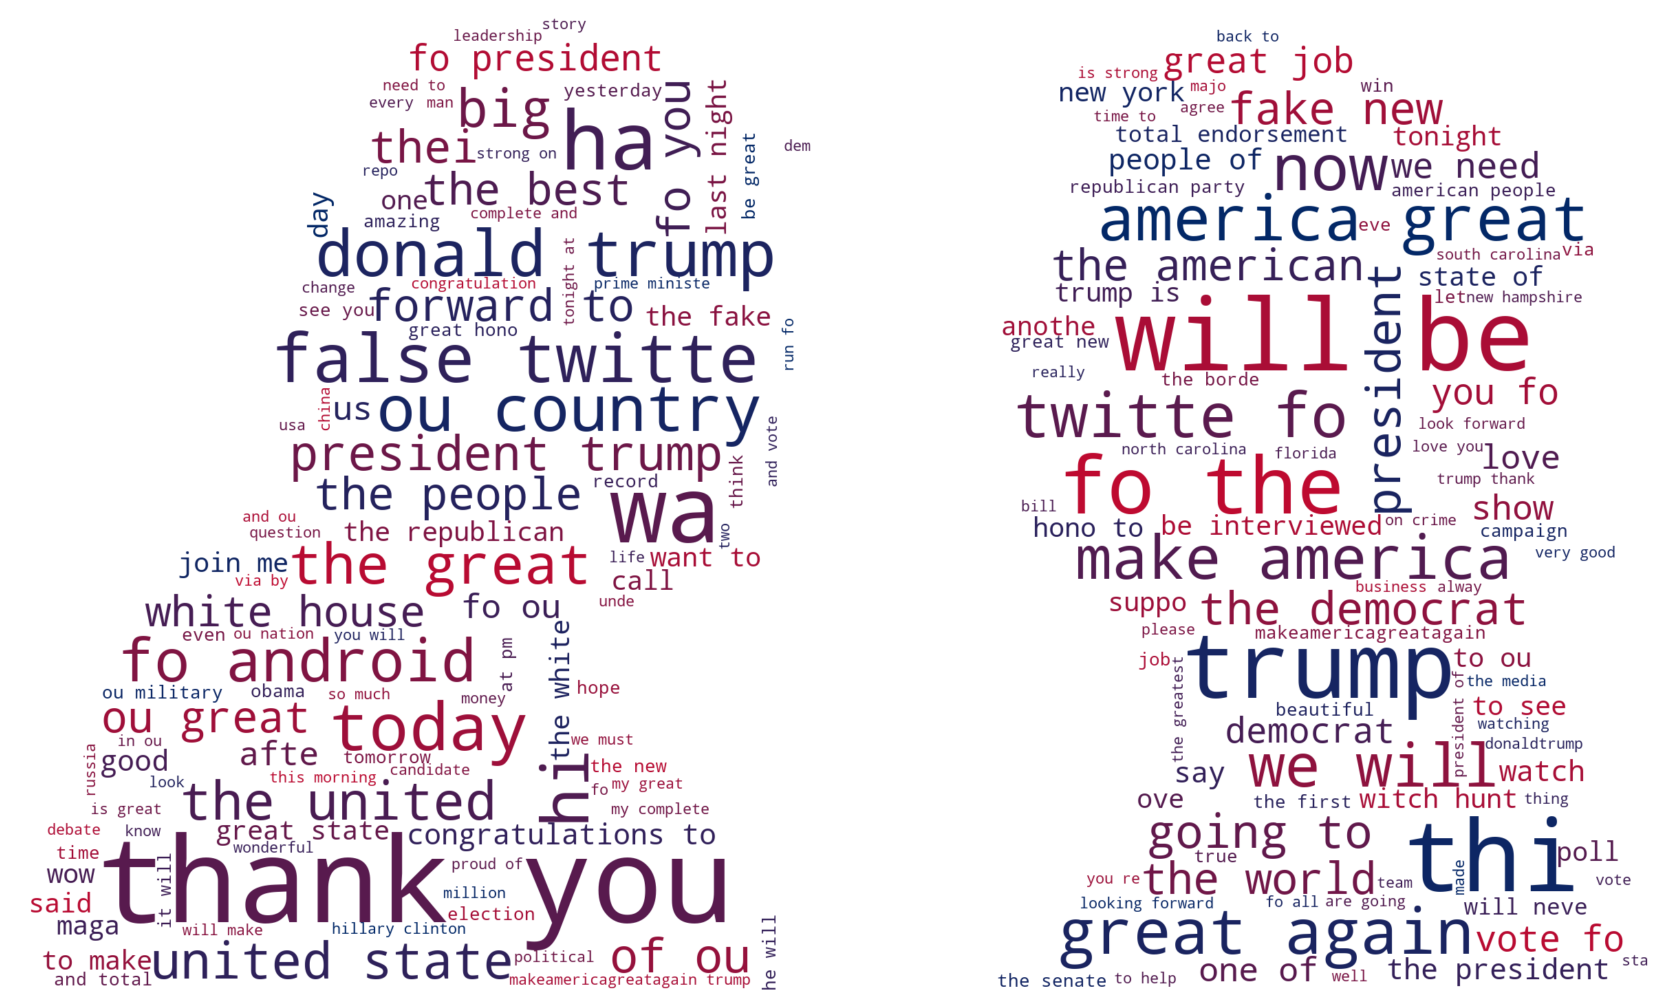

In [27]:
colors = ["#BF0A30", "#002868"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# Create WordCloud Object
wc = WordCloud(background_color="white",
                 width=853, height=506, mask=mask, colormap=cmap)
wc.generate(pos_string)


plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

## Visualización de datos

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
#Convert a collection of text documents to a matrix of token counts
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_Trump_Classified.mensaje)

CountVectorizer(stop_words='english')

In [29]:
len(cvec.get_feature_names())

19803

CountVectorizer ha extraido 16457 parabras del corpus

In [30]:
cvec.get_feature_names()

['aaa',
 'ab',
 'abaco',
 'abandon',
 'abandoned',
 'abaondon',
 'abbas',
 'abbott',
 'abc',
 'abcwashington',
 'abdeslam',
 'abdicate',
 'abdo',
 'abducted',
 'abdul',
 'abdullah',
 'abe',
 'abedin',
 'aberdeen',
 'abiding',
 'ability',
 'abingdon',
 'abiy',
 'abject',
 'ablaze',
 'able',
 'abo',
 'aboard',
 'abolish',
 'abolishice',
 'abolishing',
 'abortion',
 'abortionimmigration',
 'abou',
 'abound',
 'abraham',
 'abrams',
 'abramson',
 'abroad',
 'abrupt',
 'abruptly',
 'absentee',
 'absolute',
 'absoluteicon',
 'absolutely',
 'absurd',
 'abt',
 'abu',
 'abundance',
 'abundant',
 'abuse',
 'abused',
 'abuses',
 'abusing',
 'abusive',
 'abuts',
 'abuzz',
 'abysmal',
 'ac',
 'academia',
 'academy',
 'accelerate',
 'accelerated',
 'accentuate',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accessed',
 'accessibility',
 'accessibl',
 'accessible',
 'accessory',
 'accident',
 'accidentally',
 'accidents',
 'accolade',
 'accommodations',
 

In [31]:
neg_doc_matrix = cvec.transform(df_Trump_Classified[df_Trump_Classified.sentimiento == 0].mensaje)
pos_doc_matrix = cvec.transform(df_Trump_Classified[df_Trump_Classified.sentimiento == 1].mensaje)


In [32]:
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)

In [33]:
#squeeze function is used when we want to remove single-dimensional entries from the shape of an array.
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
type(term_freq_df)

pandas.core.frame.DataFrame

In [34]:
names = term_freq_df.columns.tolist()
names

[0, 1]

In [35]:
names = term_freq_df.columns.tolist()
names[names.index(0)] = 'negativo'
names[names.index(1)] = 'positivo'
term_freq_df.columns = names

In [36]:
term_freq_df["Total"]=term_freq_df.sum(axis=1)
term_freq_df

negativo  positivo  Total
aaa                0         5      5
ab                 0         1      1
abaco              1         0      1
abandon            5         4      9
abandoned         10         3     13
...              ...       ...    ...
zuckerberg         0         4      4
zuckerman          6         2      8
zuke               1         0      1
zumuw              0         1      1
zurich             1         0      1

[19803 rows x 3 columns]

In [37]:
term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

In [38]:
term_freq_df.sort_values(by='Total', ascending=False)

negativo  positivo  Total
fo               2388      6327   8715
great             584      4296   4880
trump             948      3788   4736
ou               1088      3167   4255
president         812      2265   3077
...               ...       ...    ...
fiu                 1         0      1
proc                0         1      1
fixating            1         0      1
problematic         0         1      1
zurich              1         0      1

[19803 rows x 3 columns]

Text(0.5, 1.0, 'Top 500 tokens in tweets')

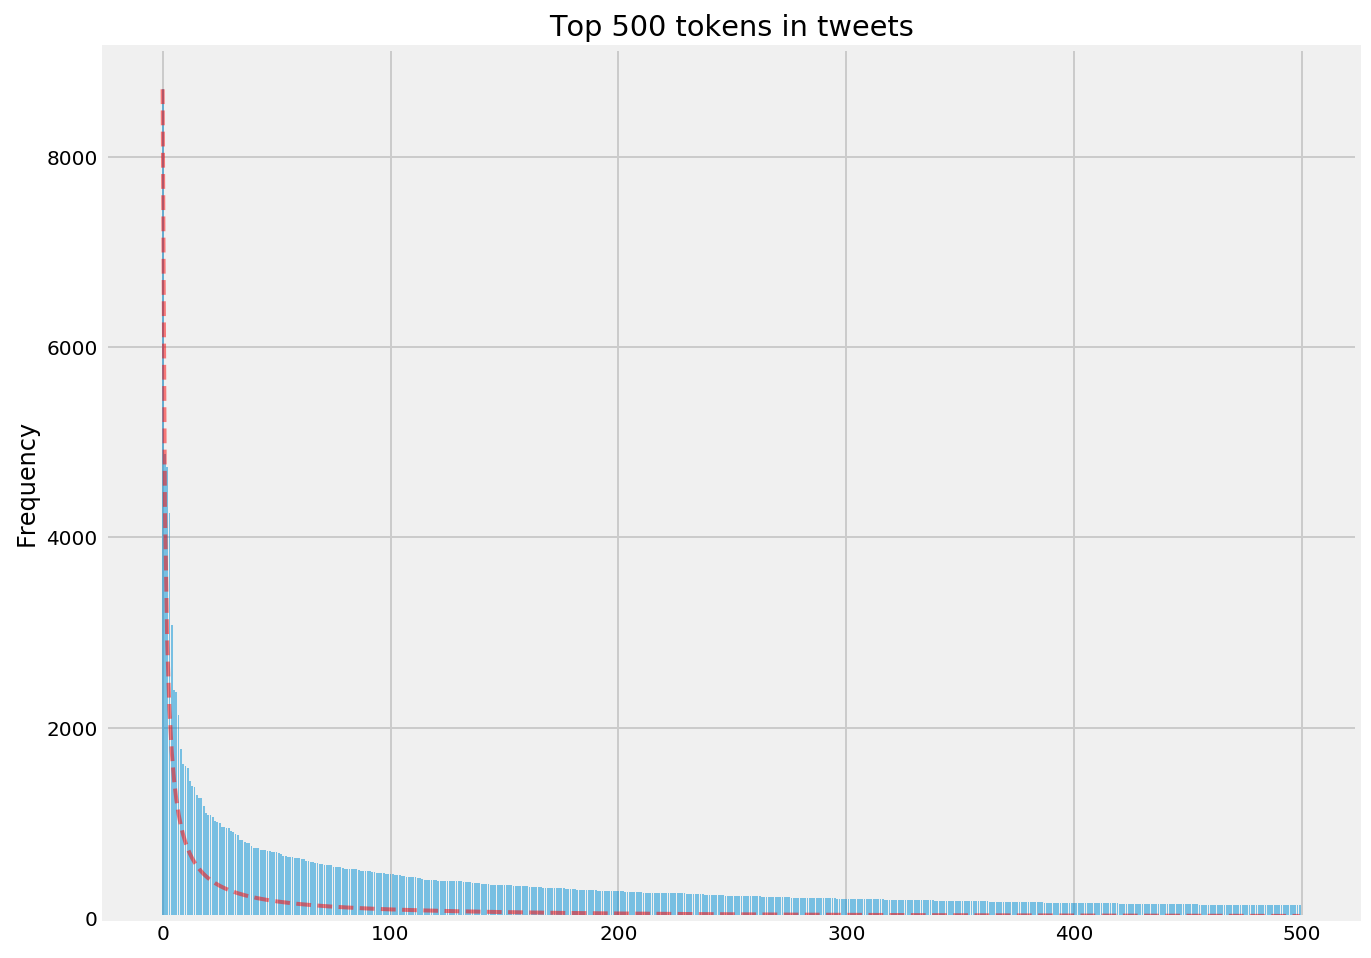

In [39]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='Total', ascending=False)['Total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='Total', ascending=False)['Total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

Par la visualización de los tokens en los tweets de Trump voy a proceder a eliminar las stopword ya que me restan significado al análisis que quiero mostrar

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(df_Trump_Classified.mensaje)

CountVectorizer(max_features=10000, stop_words='english')

In [41]:
document_matrix = cvec.transform(df_Trump_Classified.mensaje)

In [42]:
%%time
neg_batches = np.linspace(0,len(df_Trump_Classified)/2,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

1680 entries' term freuquency calculated
3360 entries' term freuquency calculated
5041 entries' term freuquency calculated
6721 entries' term freuquency calculated
8401 entries' term freuquency calculated
10082 entries' term freuquency calculated
11762 entries' term freuquency calculated
13442 entries' term freuquency calculated
15123 entries' term freuquency calculated
Wall time: 442 ms


In [43]:
%%time
pos_batches = np.linspace(len(df_Trump_Classified)/2,len(df_Trump_Classified),10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

16803 entries' term freuquency calculated
18483 entries' term freuquency calculated
20164 entries' term freuquency calculated
21844 entries' term freuquency calculated
23524 entries' term freuquency calculated
25205 entries' term freuquency calculated
26885 entries' term freuquency calculated
28565 entries' term freuquency calculated
30246 entries' term freuquency calculated
Wall time: 431 ms


In [44]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negativo', 'positivo']
term_freq_df2['Total'] = term_freq_df2['negativo'] + term_freq_df['positivo']
term_freq_df2.sort_values(by='Total', ascending=False).iloc[:10]

negativo  positivo    Total
fo             4354      4361  10681.0
great          2319      2561   6615.0
ou             2620      1635   5787.0
trump          1422      3314   5210.0
president      2002      1075   4267.0
thank          1042      1349   3394.0
people         1318      1053   2778.0
just           1095      1034   2437.0
america         709      1067   2166.0
new             897       717   2115.0

Las 40 palabras más negativas

Text(0.5, 1.0, 'Los 40 tokens más negativos en tweets')

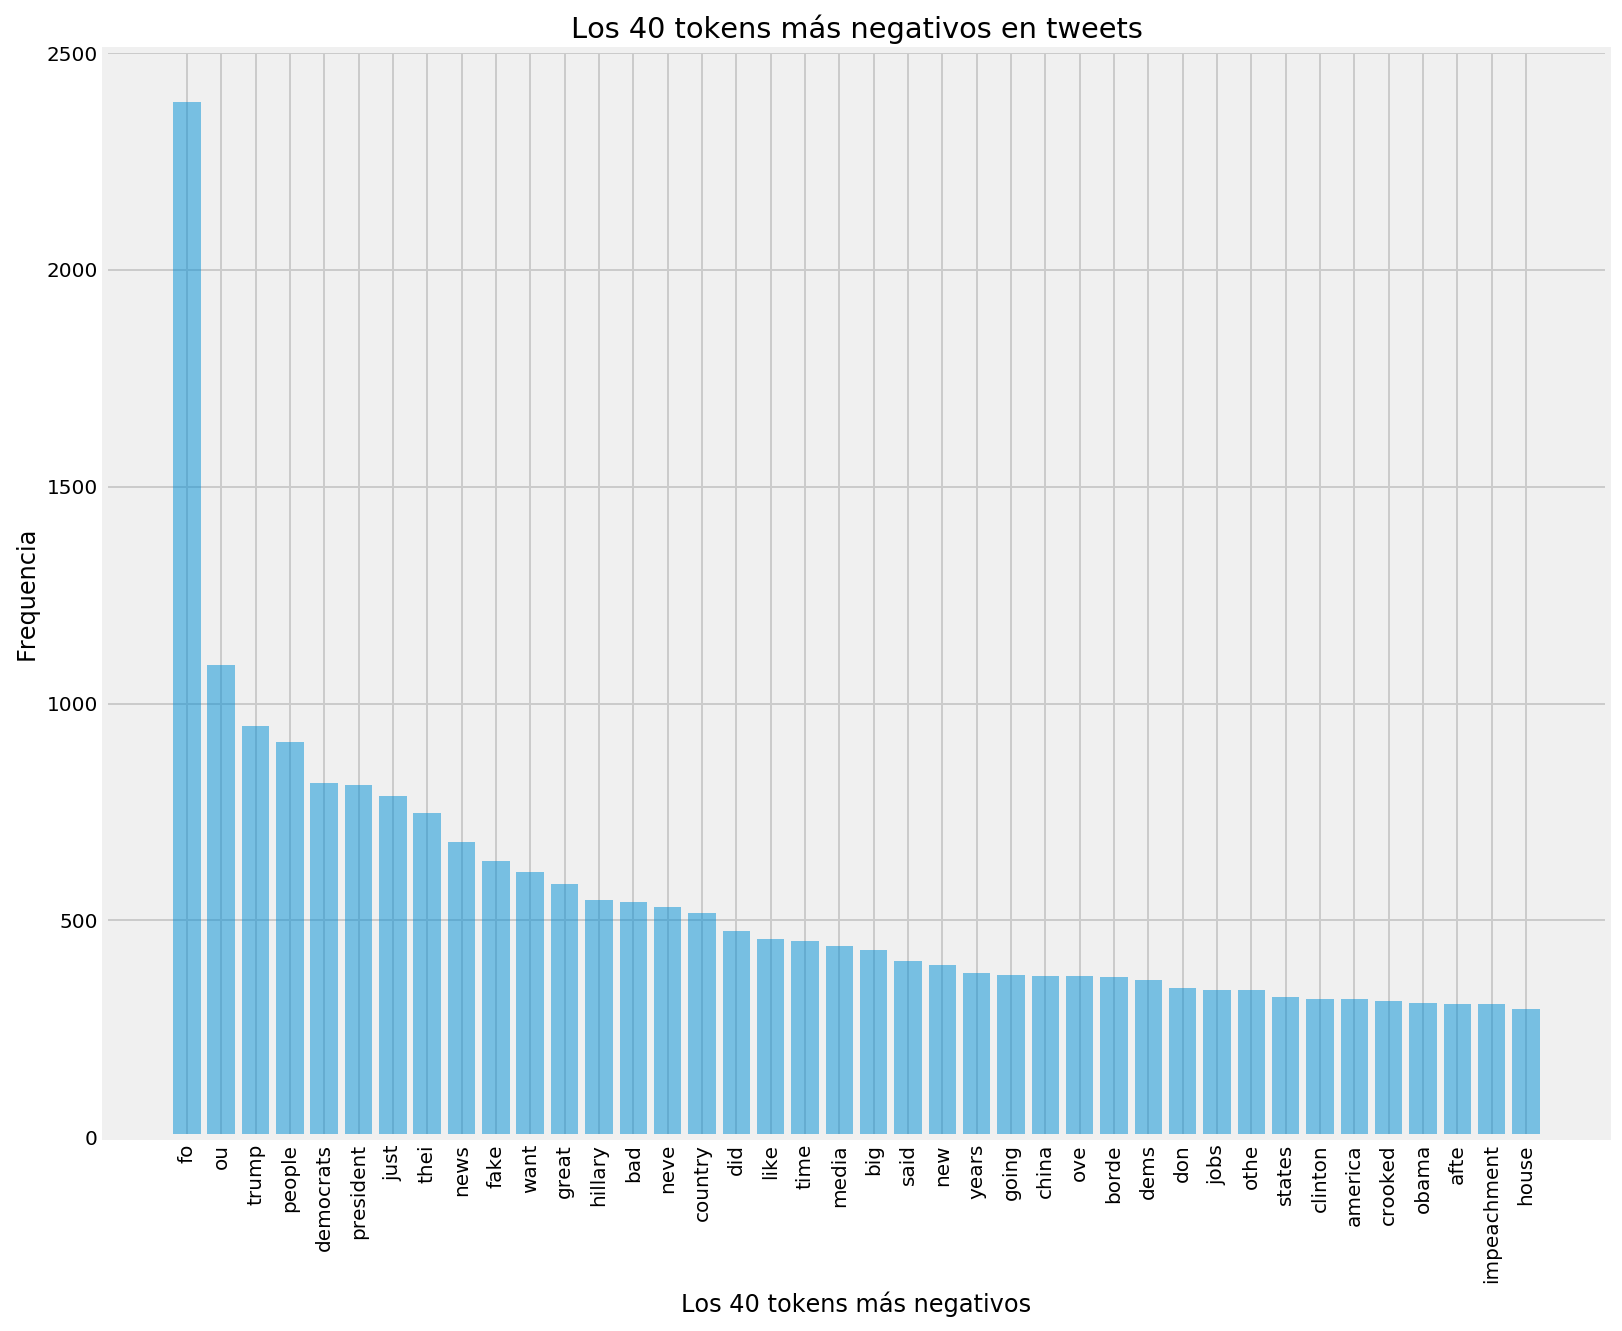

In [45]:
y_pos = np.arange(40)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negativo', ascending=False)['negativo'][:40], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negativo', ascending=False)['negativo'][:40].index,rotation='vertical')
plt.ylabel('Frequencia')
plt.xlabel('Los 40 tokens más negativos')
plt.title('Los 40 tokens más negativos en tweets')

Text(0.5, 1.0, 'Los 40 tokens más positivos en tweets')

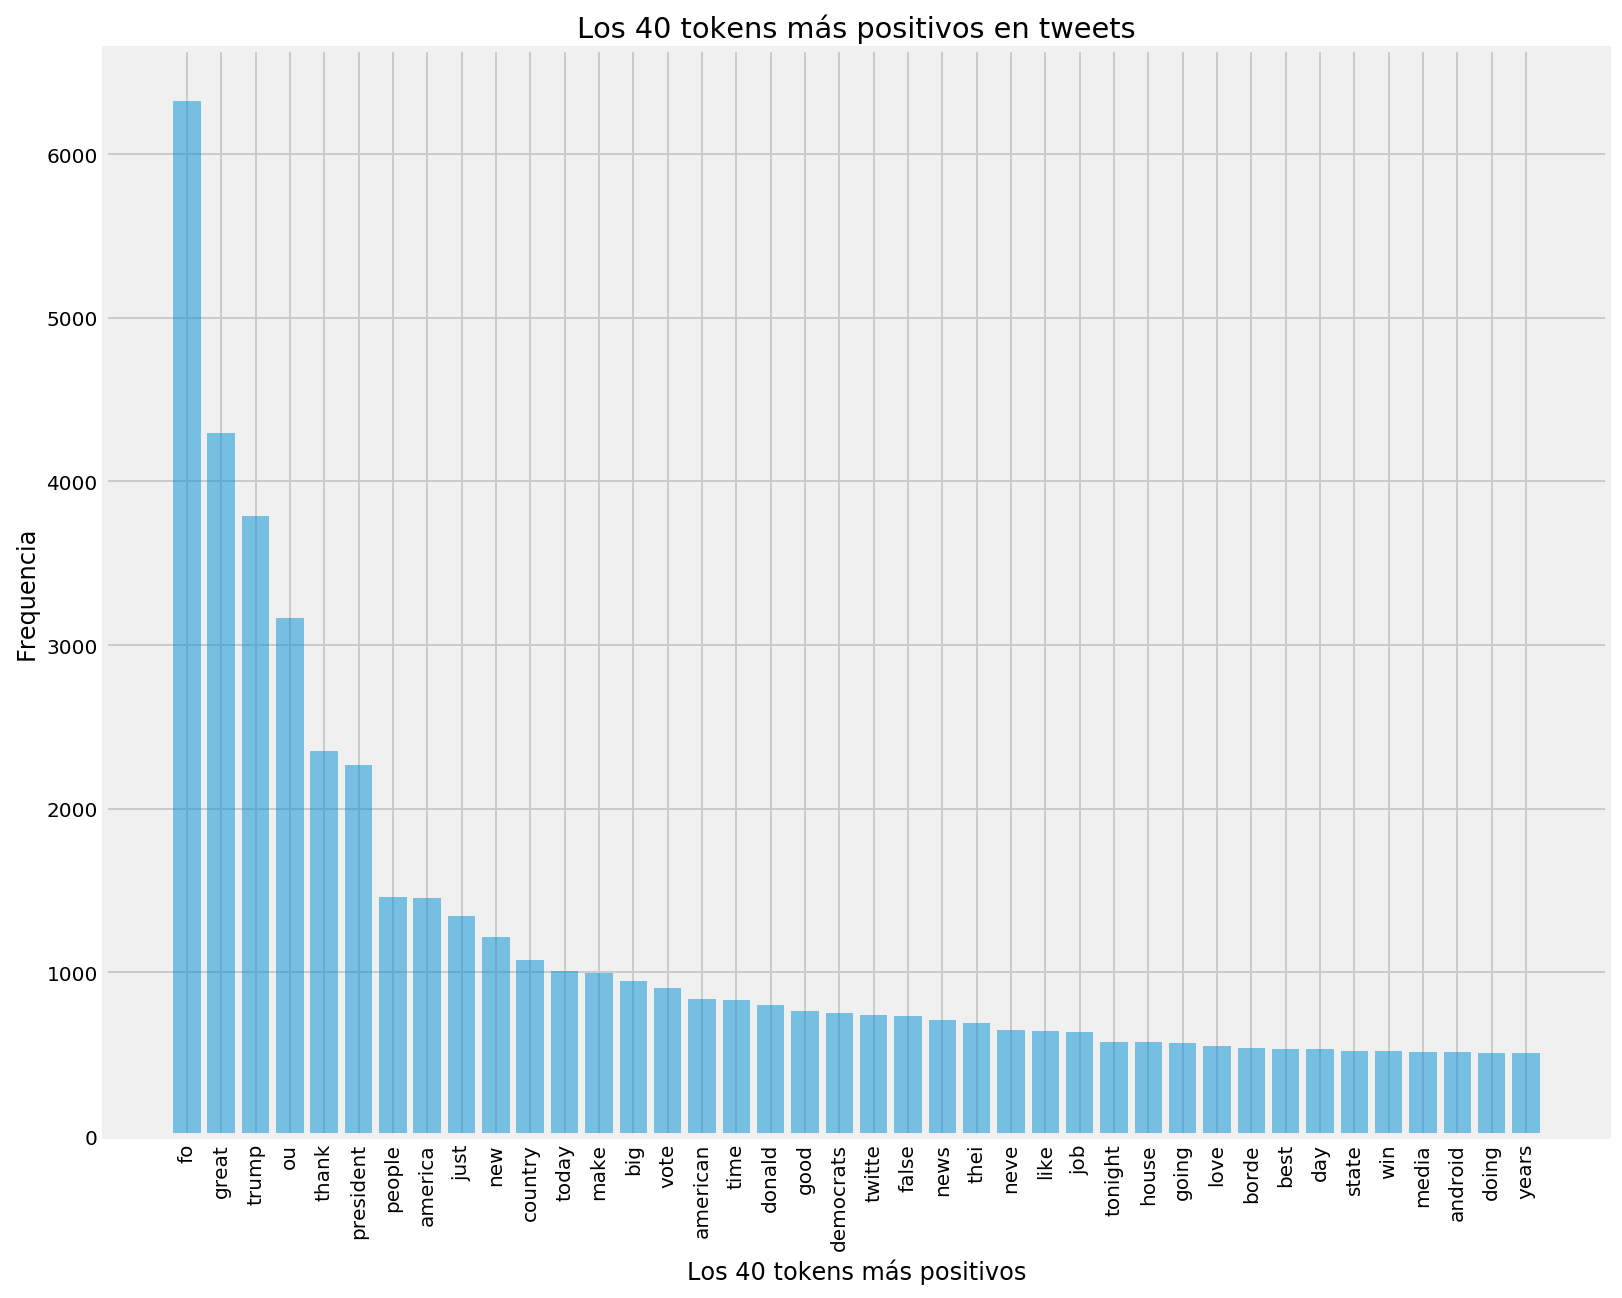

In [46]:
y_pos = np.arange(40)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positivo', ascending=False)['positivo'][:40], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positivo', ascending=False)['positivo'][:40].index,rotation='vertical')
plt.ylabel('Frequencia')
plt.xlabel('Los 40 tokens más positivos')
plt.title('Los 40 tokens más positivos en tweets')

In [47]:
df_Trump_Classified.to_csv('Trump_SA_For_LSTM.csv',encoding='utf-8')

In [48]:
df_Trump_Classified

mensaje                fecha  \
0      so obama and his team of lowlifes spied on my ...  07-24-2020 23:38:05   
1      approval rating in the republican party thank you  07-24-2020 22:57:57   
2                                                     pa  07-24-2020 21:45:30   
3                                                     pa  07-24-2020 21:45:27   
4      pa did not expect to interview at the white ho...  07-24-2020 21:45:25   
...                                                  ...                  ...   
31110  without passion you do not have energy without...  12-31-2014 15:50:39   
31111  if you re interested in balancing work and ple...  12-31-2014 15:45:09   
31112                                     run donald run  12-31-2014 03:45:08   
31113  sometimes by losing battle you find new way to...  12-31-2014 03:44:13   
31114  if one man could get this fucking country back...  12-31-2014 03:34:26   

       sentimiento  
0                0  
1                1  
2                1  
3                1  
4                1  
...            ...  
31110            0  
31111            1  
31112            1  
31113            0  
31114            1  

[30246 rows x 3 columns]

In [49]:
df = df_Trump_Classified['sentimiento'].value_counts()

In [50]:
print("Porcentaje de tweets positivos: {}%".format(df[1]*100/len(df_Trump_Classified)))
print("Porcentaje de tweets negativos: {}%".format(df[0]*100/len(df_Trump_Classified)))

Porcentaje de tweets positivos: 70.47543476823381%
Porcentaje de tweets negativos: 29.524565231766182%


In [51]:
import plotly.graph_objects as go
labels=["Porcentaje de tweets positivos", "Porcentaje de tweets negativos"]
values = [df[1]*100/len(df_Trump_Classified), df[0]*100/len(df_Trump_Classified)]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()